In [11]:
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
pandas.options.mode.chained_assignment = None

In [12]:
df = pandas.read_csv("./data/global_temps_cleaned.csv")
training_set = df[["dt", "LandAverageTemperature"]]
training_set["dt"] = pandas.to_datetime(training_set["dt"], format="%Y-%m-%d")
training_set.set_index("dt", inplace=True)
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3192 entries, 1750-01-01 to 2015-12-01
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LandAverageTemperature  3192 non-null   float64
dtypes: float64(1)
memory usage: 49.9 KB


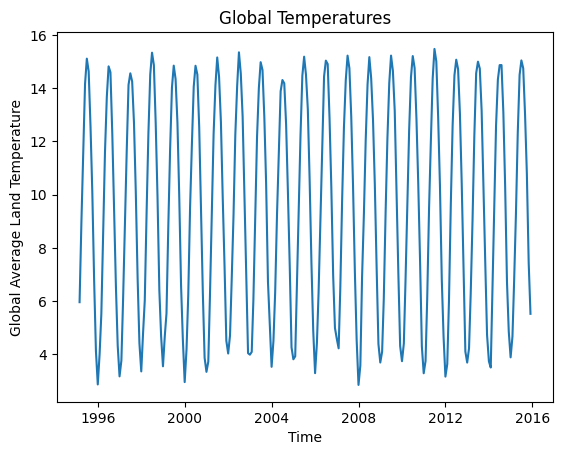

In [13]:
plt.xlabel("Time")
plt.ylabel("Global Average Land Temperature")
plt.title("Global Temperatures")
plt.plot(training_set.tail(250))

In [14]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [15]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out


Epoch: 0, loss: 0.04193
Epoch: 100, loss: 0.00280
Epoch: 200, loss: 0.00263
Epoch: 300, loss: 0.00259
Epoch: 400, loss: 0.00258
Epoch: 500, loss: 0.00257
Epoch: 600, loss: 0.00256
Epoch: 700, loss: 0.00254
Epoch: 800, loss: 0.00264
Epoch: 900, loss: 0.00250
Epoch: 1000, loss: 0.00247
Epoch: 1100, loss: 0.00245
Epoch: 1200, loss: 0.00243
Epoch: 1300, loss: 0.00241
Epoch: 1400, loss: 0.00239
Epoch: 1500, loss: 0.00237
Epoch: 1600, loss: 0.00234
Epoch: 1700, loss: 0.00232
Epoch: 1800, loss: 0.00231
Epoch: 1900, loss: 0.00229


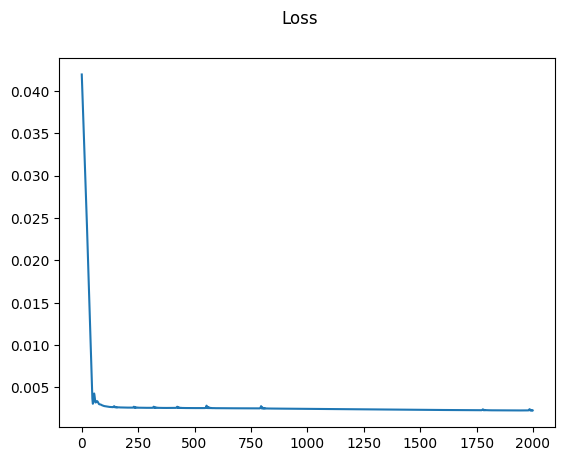

In [33]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 5
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
epoch_number = []
loss_values = []
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    
    epoch_number.append(epoch)
    loss_values.append(loss.item())
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

plt.plot(epoch_number, loss_values)
plt.suptitle('Loss')
plt.show()

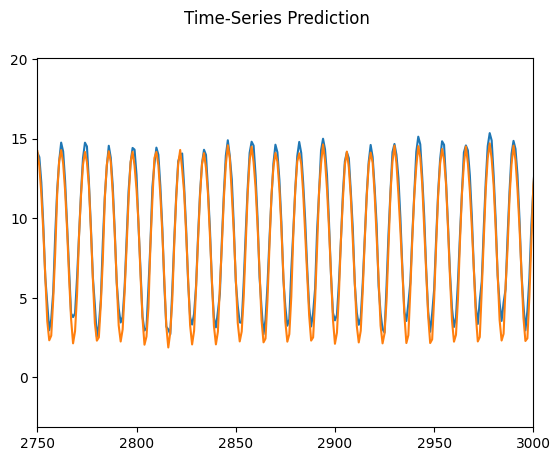

In [34]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.xlim(2750,3000)
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()